# Classification - Spambase

An attempt to replicate the results of Slack et al. with the SPAMBASE dataset. 

Main differences will be: 
- An actual Tensorflow model will be used for the 'facade' model (this may make the effect less strong). 
- SHAP only (for now)

In [1]:
# Import third party modules
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shap
import pandas as pd
import numpy as np
import random

# For visualisations
shap.initjs()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
from temp_utils import *
params = Params("temp_experiment_params.json")


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from copy import deepcopy
import sys

In [4]:
from metrics.sensitivity import calculate_sensitivity
from metrics.infidelity import calculate_infidelity


Sensitivity module imported
Dataset converter module imported
Metadata module imported
Infidelity module imported


In [5]:
# Remove 'Consider rewriting this model with the Functional API' warnings from Tensorflow
# These warnings can be ignored: https://github.com/tensorflow/recommenders/issues/188
tf.get_logger().setLevel('ERROR')

In [6]:
# Import custom modules
from metrics.sensitivity import calculate_sensitivity
from metrics.infidelity import calculate_infidelity

from model.metadata import get_feature_names, get_feature_names_of_type, append_indices, append_baselines
from model.feature_columns import get_normalization_parameters, create_numeric_columns, create_categorical_columns
from model.dataset_converter import convert_df_dataset, convert_dataframe_numpy, convert_numpy_tensor
from model.model_creation import create_fit_model

from data.classification_spam.spambase_helpers import get_names, get_metadata

Feature columns module imported


In [7]:
# Import data from csv
csv_file = 'data/classification_spam/spambase.data'
feature_names = names=get_names()
feature_names.insert(0, 'explanation_feature')
dataframe = pd.read_csv(csv_file, index_col=False, sep=',', names=get_names())

In [8]:
# Add a column which we will attempt to fool SHAP into thinking is salient
dataframe.insert(loc=0, column='explanation_feature', value=np.random.choice([0,1],size=dataframe.shape[0]))

In [9]:
# CO: don't need for now as converting to numpy
metadata = get_metadata()
# # Append indexes to metadata
metadata = append_indices(metadata)
metadata = append_baselines(metadata, dataframe)
y = dataframe.pop('class').to_numpy()
X = dataframe.to_numpy()

In [10]:
# Get indices of our main columns
capital_index = feature_names.index('capital_run_length_longest')
unrelated_index = feature_names.index('explanation_feature')

In [11]:
class biased_model_f:
    # We don't have a feature with potential for 'bias' in this dataset, so we use capital_run_length_longest
    def predict(self,X):
        if X.ndim == 1:
            X = np.array([X]) 
        return np.array([0 if x[capital_index] > 0 else 1 for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

# TODO: replace innocuous_model_psi with the actual tensorflow model (probably refactor stuff first)
class innocuous_model_psi:
    # Decision rule: classify according to randomly drawn column 'unrelated column'
    def predict(self,X):
        return np.array([params.negative_outcome if x[unrelated_index] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

In [12]:
# Split the data and normalize
xtrain,xtest,ytrain,ytest = train_test_split(X,y)
xtest_not_normalized = deepcopy(xtest)
ss = StandardScaler().fit(xtrain)
xtrain = ss.transform(xtrain)
xtest = ss.transform(xtest)

In [13]:
mlp_model = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(20, 60, 10)).fit(xtrain, ytrain)

In [14]:
mlp_model.predict(xtest)

array([1, 0, 1, ..., 0, 1, 0])

In [15]:
import json
import numpy as np
import pandas as pd

class Params():
    """Parameters object taken from: https://github.com/cs230-stanford/cs230-code-examples/blob/master/pytorch/nlp/utils.py
    
    Parameters
    ----------
    json_path : string

    Returns
    ----------
    Parameters object
    """
    def __init__(self, json_path):
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    def save(self, json_path):
        with open(json_path, 'w') as f:
            json.dump(self.__dict__, f, indent=4)

    def update(self, json_path):
        """Loads parameters from json file"""
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    @property
    def dict(self):
        """Gives dict-like access to Params instance by `params.dict['learning_rate']"""
        return self.__dict__


def one_hot_encode(y):
    """ One hot encode y for binary features.  We use this to get from 1 dim ys to predict proba's.
    This is taken from this s.o. post: https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array

    Parameters
    ----------
    y : np.ndarray

    Returns
    ----------
    A np.ndarray of the one hot encoded data.
    """
    y_hat_one_hot = np.zeros((len(y), 2))
    y_hat_one_hot[np.arange(len(y)), y] = 1
    return y_hat_one_hot

def rank_features(explanation):
    """ Given an explanation of type (name, value) provide the ranked list of feature names according to importance

    Parameters
    ----------
    explanation : list

    Returns
    ----------
    List contained ranked feature names
    """

    ordered_tuples = sorted(explanation, key=lambda x : abs(x[1]), reverse=True)  
    results = [tup[0] if tup[1] != 0 else ("Nothing shown",0) for tup in ordered_tuples]
    return results

def get_rank_map(ranks, to_consider):
    """ Give a list of feature names in their ranked positions, return a map from position ranks
    to pct occurances.

    Parameters
    ----------
    ranks : list
    to_consider : int

    Returns
    ----------
    A dictionary containing the ranks mapped to the uniques.
    """
    unique = {i+1 : [] for i in range(len(ranks))}

    for i, rank in enumerate(ranks):
        for unique_rank in np.unique(rank):
            unique[i+1].append((unique_rank, np.sum(np.array(rank) == unique_rank) / to_consider))

    return unique

def experiment_summary(explanations, features):
    """ Provide a high level display of the experiment results for the top three features.
    This should be read as the rank (e.g. 1 means most important) and the pct occurances
    of the features of interest.

    Parameters
    ----------
    explanations : list
    explain_features : list
    bias_feature : string

    Returns 
    ----------
    A summary of the experiment
    """
    # features_of_interest = explain_features + [bias_feature]   
    top_features = [[], [], []]

    # sort ranks into top 3 features
    for exp in explanations:
        ranks = rank_features(exp)
        for i in range(3):
            for f in features + ["Nothing shown"]:
                if f in ranks[i]:
                    top_features[i].append(f)

    return get_rank_map(top_features, len(explanations))


In [16]:
# import numpy as np
# import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# from sklearn.model_selection import train_test_split

from copy import deepcopy

import shap

class Adversarial_Model(object):
	"""	A scikit-learn style adversarial explainer base class for adversarial models.  This accetps 
	a scikit learn style function f_obscure that serves as the _true classification rule_ for in distribution
	data.  Also, it accepts, psi_display: the classification rule you wish to display by explainers (e.g. LIME/SHAP).
	Ideally, f_obscure will classify individual instances but psi_display will be shown by the explainer.

	Parameters
	----------
	f_obscure : function
	psi_display : function
	"""
	def __init__(self, f_obscure, psi_display):
		self.f_obscure = f_obscure
		self.psi_display = psi_display

		self.cols = None
		self.scaler = None
		self.numerical_cols = None

	def predict_proba(self, X, threshold=0.5):
		""" Scikit-learn style probability prediction for the adversarial model.  

		Parameters
		----------
		X : np.ndarray

		Returns
		----------
		A numpy array of the class probability predictions of the advesarial model.
		"""
		if self.perturbation_identifier is None:
			raise NameError("Model is not trained yet, can't perform predictions.")

		# generate the "true" predictions on the data using the "bad" model -- this is f in the paper
		predictions_to_obscure = self.f_obscure.predict_proba(X)
		# generate the "explain" predictions -- this is psi in the paper

		predictions_to_explain_by = self.psi_display.predict_proba(X)
    
		# in the case that we're only considering numerical columns
		if self.numerical_cols:
			X = X[:,self.numerical_cols]

		# MP - generate predictions of whether the point is on or off manifold
		pred_probs = self.perturbation_identifier.predict_proba(X)
        
		# allow thresholding for finetuned control over psi_display and f_obscure
		# MP - the [:,1] is just taking the second value, this is arbitrary, we could equally take [:,0] (first value)
		# and check whether <= threshold
		perturbation_preds = (pred_probs[:,1] >= threshold)

		sol = np.where(np.array([perturbation_preds == 1,perturbation_preds==1]).transpose(), predictions_to_obscure, predictions_to_explain_by)
		return sol

	def predict(self, X):
		"""	Scikit-learn style prediction. Follows from predict_proba.

		Parameters
		----------
		X : np.ndarray
		
		Returns
		----------
		A numpy array containing the binary class predictions.
		"""
        
		if X.ndim == 1:
			X = np.array([X]) 

		pred_probs = self.predict_proba(X)
		return np.argmax(pred_probs,axis=1)

	def score(self, X_test, y_test):	
		""" Scikit-learn style accuracy scoring.

		Parameters:
		----------
		X_test : X_test
		y_test : y_test

		Returns:
		----------
		A scalar value of the accuracy score on the task.
		"""

		return np.sum(self.predict(X_test)==y_test) / y_test.size

	def get_column_names(self):
		""" Access column names."""

		if self.cols is None:
			raise NameError("Train model with pandas data frame to get column names.")

		return self.cols

	def fidelity(self, X):
		""" Get the fidelity of the adversarial model to the original predictions.  High fidelity means that
		we're predicting f along the in distribution data.
		
		Parameters:
		----------
		X : np.ndarray	

		Returns:
		----------
		The fidelity score of the adversarial model's predictions to the model you're trying to obscure's predictions.
		"""

		return (np.sum(self.predict(X) == self.f_obscure.predict(X)) / X.shape[0])

class Adversarial_Kernel_SHAP_Model(Adversarial_Model):
	""" SHAP adversarial model.  Generates an adversarial model for SHAP style perturbations.

	Parameters:
	----------
	f_obscure : function
	psi_display : function
	"""
	def __init__(self, f_obscure, psi_display):
		super(Adversarial_Kernel_SHAP_Model, self).__init__(f_obscure, psi_display)

	def train(self, X, y, feature_names, background_distribution=None, perturbation_multiplier=10, n_samples=2e4, rf_estimators=100, n_kmeans=10, estimator=None):
		""" Trains the adversarial SHAP model. This method perturbs the shap training distribution by sampling from 
		its kmeans and randomly adding features.  These points get substituted into a test set.  We also check to make 
		sure that the instance isn't in the test set before adding it to the out of distribution set. If an estimator is 
		provided this is used.

		Parameters:
		----------
		X : np.ndarray
		y : np.ndarray
		features_names : list
		perturbation_multiplier : int
		n_samples : int or float
		rf_estimators : int
		n_kmeans : int
		estimator : func

		Returns:
		----------
		The model itself.
		"""
		if isinstance(X, pd.DataFrame):
			X = X.values
		elif not isinstance(X, np.ndarray):
			raise NameError("X of type {} is not accepted. Only pandas dataframes or numpy arrays allowed".format(type(X)))

		self.cols = feature_names

		# This is the mock background distribution we'll pull from to create substitutions
		if background_distribution is None:
			background_distribution = shap.kmeans(X,n_kmeans).data
		repeated_X = np.repeat(X, perturbation_multiplier, axis=0)

		new_instances = []
		equal = []

		# We generate n_samples number of substutions
		# MP - this just seems to be selecting a random instance
		for _ in range(int(n_samples)):
			i = np.random.choice(X.shape[0])
			point = deepcopy(X[i, :])

			# iterate over points, sampling and updating
			# MP - seems here we are using data for random features in order to generate points off the manifold
			for _ in range(X.shape[1]):
				j = np.random.choice(X.shape[1])
				point[j] = deepcopy(background_distribution[np.random.choice(background_distribution.shape[0]),j])
	
			new_instances.append(point)

		substituted_training_data = np.vstack(new_instances)
		all_instances_x = np.vstack((repeated_X, substituted_training_data))

		# make sure feature truly is out of distribution before labeling it
		xlist = X.tolist()
		ys = np.array([1 if substituted_training_data[val,:].tolist() in xlist else 0\
						 for val in range(substituted_training_data.shape[0])])

		all_instances_y = np.concatenate((np.ones(repeated_X.shape[0]),ys))

		xtrain,xtest,ytrain,ytest = train_test_split(all_instances_x, all_instances_y, test_size=0.2)

		if estimator is not None:
			self.perturbation_identifier = estimator.fit(xtrain,ytrain)
		else:
			self.perturbation_identifier = RandomForestClassifier(n_estimators=rf_estimators).fit(xtrain,ytrain)

		ypred = self.perturbation_identifier.predict(xtest)
		self.ood_training_task_ability = (ytest, ypred)

		return self


In [17]:
# Train the adversarial model
adv_shap = Adversarial_Kernel_SHAP_Model(biased_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=feature_names)

# Train the adversarialMLP model
adv_mlp_shap = Adversarial_Kernel_SHAP_Model(biased_model_f(), mlp_model).\
            train(xtrain, ytrain, feature_names=feature_names)

In [18]:
mock = xtest[0]
# mock[56] = 1

adv_mlp_shap.predict(mock)

array([1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.10434783 0.        ]]


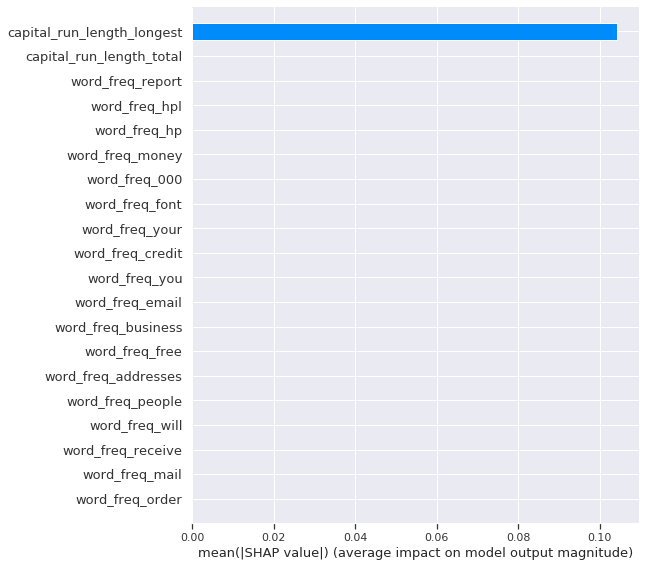

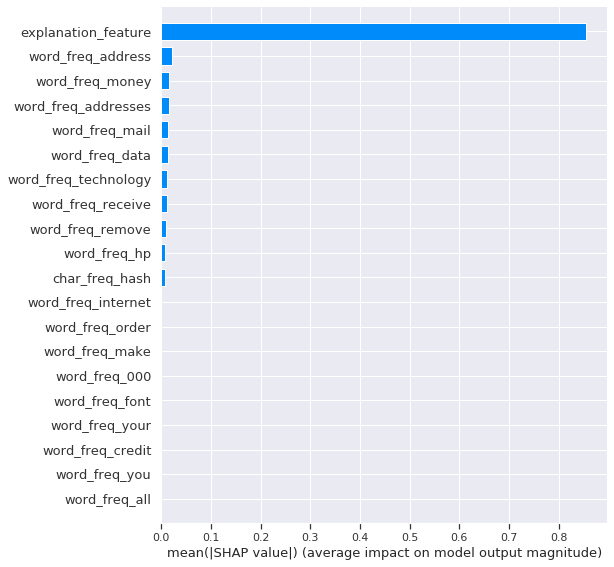

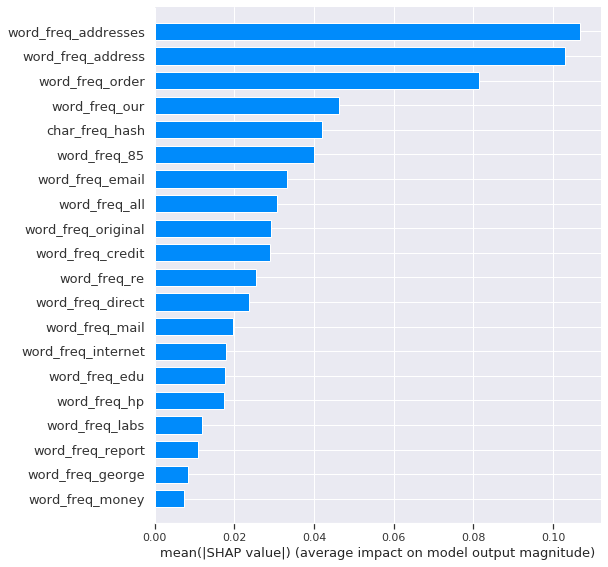

Fidelity: 1.0
Fidelity: 1.0


In [19]:
# Set the background distribution for the shap explainer using kmeans
background_distribution = shap.kmeans(xtrain,10)

# Let's use the shap kernel explainer and grab a point to explain
to_examine = np.random.choice(xtest.shape[0])

# Explain the biased model
biased_kernel_explainer = shap.KernelExplainer(biased_model_f().predict, background_distribution)
biased_shap_values = biased_kernel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Explain the adversarial model
adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Explain the adversarialMLP model
adv_mlp_kerenel_explainer = shap.KernelExplainer(adv_mlp_shap.predict, background_distribution)
adv_mlp_shap_values = adv_mlp_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Plot it using SHAP's plotting features.
print(np.array(biased_shap_values))
shap.summary_plot(np.array(biased_shap_values), feature_names=feature_names, plot_type="bar")
shap.summary_plot(adv_shap_values, feature_names=feature_names, plot_type="bar")
shap.summary_plot(adv_mlp_shap_values, feature_names=feature_names, plot_type="bar")

# Note - fidelity here completely different to primary use in this work
print ("Fidelity: {0:3.2}".format(adv_shap.fidelity(xtest[to_examine:to_examine+1])))
print ("Fidelity: {0:3.2}".format(adv_mlp_shap.fidelity(xtest[to_examine:to_examine+1])))

In [20]:
xtest[to_examine:to_examine+1]

array([[-1.00873379, -0.34466096, -0.16563027, -0.56275318, -0.03351922,
        -0.46975652, -0.34406898, -0.2877501 , -0.28183008, -0.3232492 ,
        -0.39654817, -0.29698269, -0.62771263, -0.31603005, -0.17160391,
        -0.19092277, -0.29217025, -0.32046055, -0.35684289, -0.93691872,
        -0.16277257, -0.66374538, -0.12052926, -0.29704786, -0.21299425,
        -0.32632795, -0.2927054 , -0.21621482, -0.23027247, -0.17179737,
        -0.22257374, -0.15165277, -0.1393769 , -0.19771941, -0.14170306,
        -0.18417959, -0.24733396, -0.32184874, -0.05650981, -0.18766507,
        -0.18389924, -0.12469523, -0.17390821, -0.19841501, -0.12854824,
        -0.29108119, -0.20171234, -0.0704173 , -0.1100095 , -0.16059682,
        -0.57994023, -0.15022812, -0.38316039, -0.31069925, -0.10322376,
        -0.10369625, -0.35474704, -0.50924724]])

In [21]:
adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1][0])
adv_shap_values

array([0.86782451, 0.        , 0.        , 0.        , 0.        ,
       0.0151651 , 0.        , 0.        , 0.        , 0.02418937,
       0.        , 0.        , 0.        , 0.        , 0.01578362,
       0.02174866, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02024616,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02431795,
       0.        , 0.        , 0.        ])

In [22]:
# Check we can call predict() in the usual way on the adversarial model

instance = xtest[23]
adv_shap.predict(xtest)

array([1, 1, 1, ..., 1, 1, 1])

In [23]:
xtest[to_examine:to_examine+1][0]

array([-1.00873379, -0.34466096, -0.16563027, -0.56275318, -0.03351922,
       -0.46975652, -0.34406898, -0.2877501 , -0.28183008, -0.3232492 ,
       -0.39654817, -0.29698269, -0.62771263, -0.31603005, -0.17160391,
       -0.19092277, -0.29217025, -0.32046055, -0.35684289, -0.93691872,
       -0.16277257, -0.66374538, -0.12052926, -0.29704786, -0.21299425,
       -0.32632795, -0.2927054 , -0.21621482, -0.23027247, -0.17179737,
       -0.22257374, -0.15165277, -0.1393769 , -0.19771941, -0.14170306,
       -0.18417959, -0.24733396, -0.32184874, -0.05650981, -0.18766507,
       -0.18389924, -0.12469523, -0.17390821, -0.19841501, -0.12854824,
       -0.29108119, -0.20171234, -0.0704173 , -0.1100095 , -0.16059682,
       -0.57994023, -0.15022812, -0.38316039, -0.31069925, -0.10322376,
       -0.10369625, -0.35474704, -0.50924724])

In [24]:
# sensitivity = calculate_sensitivity(adv_kerenel_explainer.shap_values, adv_shap_values, xtest[to_examine:to_examine+1][0], metadata)
# sensitivity

In [25]:
xtest[to_examine:to_examine+1][0]

array([-1.00873379, -0.34466096, -0.16563027, -0.56275318, -0.03351922,
       -0.46975652, -0.34406898, -0.2877501 , -0.28183008, -0.3232492 ,
       -0.39654817, -0.29698269, -0.62771263, -0.31603005, -0.17160391,
       -0.19092277, -0.29217025, -0.32046055, -0.35684289, -0.93691872,
       -0.16277257, -0.66374538, -0.12052926, -0.29704786, -0.21299425,
       -0.32632795, -0.2927054 , -0.21621482, -0.23027247, -0.17179737,
       -0.22257374, -0.15165277, -0.1393769 , -0.19771941, -0.14170306,
       -0.18417959, -0.24733396, -0.32184874, -0.05650981, -0.18766507,
       -0.18389924, -0.12469523, -0.17390821, -0.19841501, -0.12854824,
       -0.29108119, -0.20171234, -0.0704173 , -0.1100095 , -0.16059682,
       -0.57994023, -0.15022812, -0.38316039, -0.31069925, -0.10322376,
       -0.10369625, -0.35474704, -0.50924724])

In [26]:
infidelity = calculate_infidelity(adv_shap_values, adv_shap, np.array(xtest[to_examine:to_examine+1][0]), metadata)

In [27]:
infidelity

array([85.38967754])

In [28]:
# Loop through first 10 test instances
# Loop through three different models
# Calculate fidelity, sensitivity

In [29]:
comparison = pd.DataFrame(columns=['model', 'prediction', 'instance_index', 'explanation', 'sensitivity', 'infidelity'])

In [30]:
# First 10 test instances

biased_model = biased_model_f()
for idx in range(10):
    print(f'Starting index: {idx}')
    instance = np.array([xtest[idx]])
    
    # Biased model
    biased_prediction = biased_model.predict(instance)[0]
    biased_kernel_explainer = shap.KernelExplainer(biased_model.predict, background_distribution)
    biased_shap_values = biased_kernel_explainer.shap_values(instance, silent=True)
    biased_sensitivity = calculate_sensitivity(biased_kernel_explainer.shap_values, biased_shap_values, instance[0], metadata)
    biased_infidelity = calculate_infidelity(biased_shap_values[0], biased_model, instance[0], metadata)
    comparison = comparison.append({
        'model': 'biased',
        'prediction': biased_prediction,
        'instance_index': idx,
        'explanation': biased_shap_values,
        'sensitivity': biased_sensitivity,
        'infidelity': biased_infidelity
    }, ignore_index=True)

    # Adversarial model - simple
    adv_simple_prediction = adv_shap.predict(instance)[0]
    adv_simple_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
    adv_simple_shap_values = adv_simple_explainer.shap_values(instance, silent=True)
    adv_simple_sensitivity = calculate_sensitivity(adv_simple_explainer.shap_values, adv_simple_shap_values, instance[0], metadata)
    adv_simple_infidelity = calculate_infidelity(adv_simple_shap_values[0], adv_shap, instance[0], metadata)
    comparison = comparison.append({
        'model': 'adversarial_simple',
        'prediction': adv_simple_prediction,
        'instance_index': idx,
        'explanation': adv_simple_shap_values,
        'sensitivity': adv_simple_sensitivity,
        'infidelity': adv_simple_infidelity
    }, ignore_index=True)

    # Adversarial model - MLP
    adv_mlp_prediction = adv_mlp_shap.predict(instance)[0]
    adv_mlp_explainer = shap.KernelExplainer(adv_mlp_shap.predict, background_distribution)
    adv_mlp_shap_values = adv_mlp_explainer.shap_values(instance, silent=True)
    adv_mlp_sensitivity = calculate_sensitivity(adv_mlp_explainer.shap_values, adv_mlp_shap_values, instance[0], metadata)
    adv_mlp_infidelity = calculate_infidelity(adv_mlp_shap_values[0], adv_mlp_shap, instance[0], metadata)
    comparison = comparison.append({
        'model': 'adversarial_mlp',
        'prediction': adv_mlp_prediction,
        'instance_index': idx,
        'explanation': adv_mlp_shap_values,
        'sensitivity': adv_mlp_sensitivity,
        'infidelity': adv_mlp_infidelity
    }, ignore_index=True)

Starting index: 0
Starting index: 1
Starting index: 2
Starting index: 3
Starting index: 4
Starting index: 5
Starting index: 6
Starting index: 7
Starting index: 8
Starting index: 9


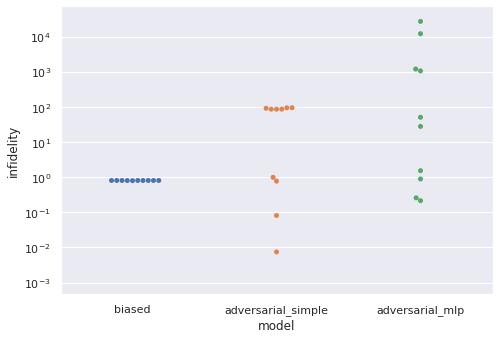

In [31]:
fig = plt.figure()
rect = 0,0,1,1 # create an rectangle for the new axis
log_ax = fig.add_axes(rect) # create a new axis (or use an existing one)
log_ax.set_yscale("log") # log first
sns.swarmplot(x='model', y='infidelity', data=comparison, ax=log_ax)

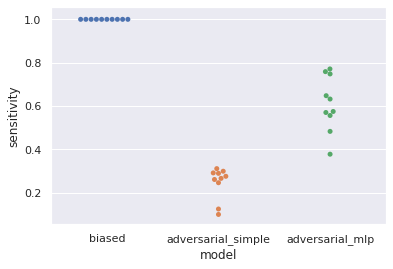

In [32]:
fig = plt.figure()
sns.swarmplot(x='model', y='sensitivity', data=comparison)